**IMPORTING REQUIRED LIBRARIES**

In [ ]:
# Libraries
import numpy as np
from tqdm import tqdm
from time import time
from PIL import Image

import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss, Conv2d, AvgPool2d, BatchNorm2d, Dropout2d, LeakyReLU, Linear, Module
from torch.utils.data import DataLoader

from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**LOADING THE DATA AND CARRYING OUT THE TRANSFORMATIONS**

In [ ]:
# Data Transformer
tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [ ]:
# Create Dataset
TRAIN_ROOT = "/content/drive/MyDrive/New Dataset/train"
TEST_ROOT = "/content/drive/MyDrive/New Dataset/test"

train_ds = ImageFolder(TRAIN_ROOT, transform = tfm)
test_ds = ImageFolder(TEST_ROOT, transform = tfm)

# Length of Train and Test Datasets
len_train = len(train_ds)
len_test = len(test_ds)

In [ ]:
# Index Mapping
train_ds.class_to_idx

{'fresh': 0, 'non-fresh': 1}

In [ ]:
# Data Loader
train_loader = DataLoader(train_ds, batch_size = 30, shuffle=True)
test_loader = DataLoader(test_ds, batch_size = 30, shuffle=True)

**BUILDING THE MODEL**

In [ ]:
# Build Model
class FishyCNN(Module):
    def __init__(self):
        super(FishyCNN, self).__init__()
        self.conv = Conv2d(in_channels=3, out_channels=8, kernel_size=(3,3), stride=1, padding=1)
        self.pool = AvgPool2d(kernel_size=(3,3), stride=1)
        self.relu = LeakyReLU()
        self.bn = BatchNorm2d(num_features=8)
        self.drop = Dropout2d(p=0.3)
        self.fc = Linear(in_features=8*126*126, out_features=2)

    def forward(self, X):
        output = self.conv(X)
        output = self.pool(output)
        output = self.relu(output)
        output = self.bn(output)
        output = self.drop(output)
#         print(output.shape)
        output = output.view(-1, 8*126*126)
        output = self.fc(output)
        return output


In [ ]:
# Define Model and Migrate to GPU
model = FishyCNN().to(device)

In [ ]:
# Optimiser
optimiser = Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)

# Loss Function
loss_fn = CrossEntropyLoss()

**TRAINING AND EVALUATING THE MODEL**

In [ ]:
for epoch in range(20):
    start = time()
    train_acc = 0
    test_acc = 0

# Train
    model.train()
    with tqdm(train_loader, unit="batch") as tepoch:
        for xtrain, ytrain in tepoch:
            optimiser.zero_grad()
            xtrain = xtrain.to(device)
            train_prob = model(xtrain)
            train_prob = train_prob.cpu()
            train_loss = loss_fn(train_prob, ytrain)
            train_loss.backward()
            optimiser.step()
            # END TRAIN
            train_pred = torch.max(train_prob, 1).indices
            train_acc += int(torch.sum(train_pred == ytrain))

        train_epoch_accuracy = train_acc / len_train

# Evaluate
    model.eval()
    with torch.no_grad():
        for xtest, ytest in test_loader:
            xtest = xtest.to(device)
            test_prob = model(xtest)
            test_prob = test_prob.cpu()
            test_loss = loss_fn(test_prob, ytest)
            test_pred = torch.max(test_prob, 1).indices
            test_acc += int(torch.sum(test_pred == ytest))

        test_epoch_accuracy = test_acc / len_test

    end = time()

    diff = end - start

    print(f"Epoch: {epoch+1}"+f"Time: {diff}"+f"Tr_loss: {train_loss}"+f" Test_loss: {test_loss}"+f"Tr_acc:{train_epoch_accuracy}"+f" Test_acc: {test_epoch_accuracy}")

100%|██████████| 3/3 [00:00<00:00,  3.12batch/s]


Epoch: 1Time: 1.0114374160766602Tr_loss: 0.0 Test_loss: 5.662435000886035e-07Tr_acc:1.0 Test_acc: 1.0


100%|██████████| 3/3 [00:00<00:00,  3.09batch/s]


Epoch: 2Time: 1.0227391719818115Tr_loss: 0.0 Test_loss: 0.0001401210465701297Tr_acc:1.0 Test_acc: 1.0


100%|██████████| 3/3 [00:00<00:00,  3.02batch/s]


Epoch: 3Time: 1.04606032371521Tr_loss: 1.4901158529312397e-08 Test_loss: 6.914044206496328e-06Tr_acc:0.9880952380952381 Test_acc: 1.0


100%|██████████| 3/3 [00:00<00:00,  3.10batch/s]


Epoch: 4Time: 1.0217151641845703Tr_loss: 9.934105982267738e-09 Test_loss: 2.4323253631591797Tr_acc:1.0 Test_acc: 0.75


100%|██████████| 3/3 [00:00<00:00,  3.10batch/s]


Epoch: 5Time: 1.0218820571899414Tr_loss: 0.0 Test_loss: 2.56103253364563Tr_acc:1.0 Test_acc: 0.75


100%|██████████| 3/3 [00:00<00:00,  3.10batch/s]


Epoch: 6Time: 1.021440029144287Tr_loss: 0.0 Test_loss: 13.218670845031738Tr_acc:1.0 Test_acc: 0.5


100%|██████████| 3/3 [00:01<00:00,  2.97batch/s]


Epoch: 7Time: 1.059269666671753Tr_loss: 0.0 Test_loss: 6.734160423278809Tr_acc:1.0 Test_acc: 0.5


100%|██████████| 3/3 [00:00<00:00,  3.10batch/s]


Epoch: 8Time: 1.0202674865722656Tr_loss: 0.45606860518455505 Test_loss: 11.847615242004395Tr_acc:0.9761904761904762 Test_acc: 0.5


100%|██████████| 3/3 [00:01<00:00,  2.40batch/s]


Epoch: 9Time: 1.3245558738708496Tr_loss: 9.02441479411209e-06 Test_loss: 4.58603572845459Tr_acc:1.0 Test_acc: 0.75


100%|██████████| 3/3 [00:01<00:00,  2.07batch/s]


Epoch: 10Time: 1.5235044956207275Tr_loss: 1.7881355063309456e-07 Test_loss: 5.011195182800293Tr_acc:0.9880952380952381 Test_acc: 0.75


100%|██████████| 3/3 [00:01<00:00,  2.33batch/s]


Epoch: 11Time: 1.3416633605957031Tr_loss: 0.0 Test_loss: 0.0Tr_acc:1.0 Test_acc: 1.0


100%|██████████| 3/3 [00:00<00:00,  3.14batch/s]


Epoch: 12Time: 1.0068063735961914Tr_loss: 0.0002529527118895203 Test_loss: 1.1920926112907182e-07Tr_acc:1.0 Test_acc: 1.0


100%|██████████| 3/3 [00:00<00:00,  3.14batch/s]


Epoch: 13Time: 1.0092403888702393Tr_loss: 0.0 Test_loss: 0.01265371311455965Tr_acc:1.0 Test_acc: 1.0


100%|██████████| 3/3 [00:00<00:00,  3.16batch/s]


Epoch: 14Time: 1.0064401626586914Tr_loss: 0.02843889780342579 Test_loss: 0.00023243942996487021Tr_acc:1.0 Test_acc: 1.0


100%|██████████| 3/3 [00:01<00:00,  3.00batch/s]


Epoch: 15Time: 1.0531914234161377Tr_loss: 4.420654420300707e-07 Test_loss: 1.442390748707112e-05Tr_acc:1.0 Test_acc: 1.0


100%|██████████| 3/3 [00:00<00:00,  3.10batch/s]


Epoch: 16Time: 1.0223536491394043Tr_loss: 5.9604616353681195e-08 Test_loss: 0.0Tr_acc:0.9880952380952381 Test_acc: 1.0


100%|██████████| 3/3 [00:01<00:00,  3.00batch/s]


Epoch: 17Time: 1.0577383041381836Tr_loss: 0.0 Test_loss: 0.0Tr_acc:1.0 Test_acc: 1.0


100%|██████████| 3/3 [00:00<00:00,  3.01batch/s]


Epoch: 18Time: 1.0534095764160156Tr_loss: 0.0038760926108807325 Test_loss: 0.0Tr_acc:1.0 Test_acc: 1.0


100%|██████████| 3/3 [00:00<00:00,  3.01batch/s]


Epoch: 19Time: 1.0503389835357666Tr_loss: 0.0 Test_loss: 2.9802320611338473e-08Tr_acc:1.0 Test_acc: 1.0


100%|██████████| 3/3 [00:00<00:00,  3.02batch/s]

Epoch: 20Time: 1.0626614093780518Tr_loss: 1.9868210188178637e-08 Test_loss: 0.0Tr_acc:1.0 Test_acc: 1.0


**MODEL PERFORMANCE ON SAMPLES**

In [ ]:
# Image Samples
sample_1 = '/content/drive/MyDrive/New Dataset/train/fresh/20200517_085346_jpg.rf.81c1a45a262c5c6030db9a7d2e0f2d7f.jpg'
sample_2 = '/content/drive/MyDrive/New Dataset/train/non-fresh/20200517_145932_jpg.rf.66c032dd0810adfd947c1576f052173d.jpg'
sample_3 = '/content/drive/MyDrive/New Dataset/valid/fresh/20200517_084741_jpg.rf.71c6a132f5d936f60c2655ac9c1d6e48.jpg'
sample_4 = '/content/drive/MyDrive/New Dataset/valid/non-fresh/20200517_145715_jpg.rf.3ff343e8477cf04140b7f40e0dfb803a.jpg'

sample_list = [sample_1,sample_2,sample_3,sample_4]

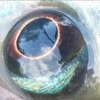

Model Pred: 0
Interpretation: This is fresh


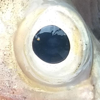

Model Pred: 1
Interpretation: It's not fresh


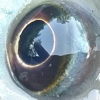

Model Pred: 0
Interpretation: This is fresh


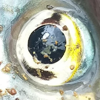

Model Pred: 1
Interpretation: It's not fresh


In [ ]:
# Model Performance
for img_path in sample_list:
    img = Image.open(img_path)
    display(img.resize((100, 100)))
    img_tensor = tfm(img)
    img_tensor = img_tensor[np.newaxis, :]
    img_tensor = img_tensor.to(device)
    prob = model(img_tensor)
    pred = torch.max(prob, 1).indices
    pred = pred.item()
    if pred == 0:
        print(f"Model Pred: {pred}\nInterpretation: This is fresh")
    else:
        print(f"Model Pred: {pred}\nInterpretation: It's not fresh")

    print("===============================================================")

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report